In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [3]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split

from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train'), sample_n=8000)
X_test, y_test = read_data(get_dataset('valid'), sample_n=2000)
# X_train, y_train = read_data(get_dataset('train'), sample_n=100)
# X_test, y_test = read_data(get_dataset('valid'), sample_n=100)

2018-12-04 13:04:02,226 [INFO] Reading /opt/storage/train/sentiment_analysis_trainingset.csv.tokenized.csv..
2018-12-04 13:04:04,626 [INFO] Reading /opt/storage/train/sentiment_analysis_trainingset.csv..
2018-12-04 13:04:07,298 [INFO] Take 8000 samples with random state 1
2018-12-04 13:04:07,333 [INFO] Reading /opt/storage/valid/sentiment_analysis_validationset.csv.tokenized.csv..
2018-12-04 13:04:07,662 [INFO] Reading /opt/storage/valid/sentiment_analysis_validationset.csv..
2018-12-04 13:04:07,934 [INFO] Take 2000 samples with random state 1


In [4]:
# del fm['tfidf_sv']
# del fm['tfidf_sv_dense']
# del fm['lsa_200_sv']
# del fm['lsa_500_sv']
# del fm['count_tiny']

In [5]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [6]:
from fgclassifier.features import FeaturePipeline, logger

def build_features(fm_names, fm):
    for name in fm_names:
        logger.info(f'Building features for {name}...')
        model = FeaturePipeline.from_spec(name, cache=fm)
        model.fit_transform(X_train)
        model.transform(X_test)
    
build_features(['count', 'count_sv', 'count_tiny'], fm)

2018-12-04 13:04:09,026 [INFO] 'pattern' package not found; tag filters are not available for English
2018-12-04 13:04:09,042 [INFO] Building features for count...
2018-12-04 13:04:09,043 [INFO] Fit & Transform CountVectorizer...
2018-12-04 13:04:49,903 [INFO] Vocab Size: 3573
2018-12-04 13:04:52,038 [INFO] Building features for count_sv...
2018-12-04 13:04:52,039 [INFO] Fit & Transform CountVectorizer...
2018-12-04 13:05:34,404 [INFO] Vocab Size: 1704
2018-12-04 13:05:36,732 [INFO] Building features for count_tiny...
2018-12-04 13:05:36,741 [INFO] Fit & Transform CountVectorizer...
2018-12-04 13:06:20,862 [INFO] Vocab Size: 1694


Exam the quality of the top terms:

In [7]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count', 'count_sv', 'count_tiny']:
    model = fm[mn]['model'].named_steps[mn]
    key = next(filter(lambda x: 'fit_transform' in x, fm[mn].keys()))
    x_train = fm[mn][key]
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.3f, max_df: %.3f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:5]]))

Data Shape: (8000,) (2000,)

min_df: 0.010, max_df: 0.800, ngram_range: (1, 5)

vocab size: 3573

吃 	 18487
！ 	 14847
都 	 13361
有 	 12560
就 	 11860

min_df: 0.020, max_df: 0.800, ngram_range: (1, 5)

vocab size: 1704

吃 	 18487
！ 	 14847
都 	 13361
有 	 12560
就 	 11860

min_df: 0.020, max_df: 0.600, ngram_range: (1, 5)

vocab size: 1694

！ 	 14847
我 	 11366
和 	 8712
感觉 	 6914
可以 	 6770


Save the word count features, as it is pretty slow to run for the whole dataset...

In [8]:
from sklearn.externals import joblib


def partial_get(d, keyword):
    key = next(filter(lambda x: x.startswith(keyword), d.keys()))
    return d[key]

def save_transform_cache(mn, path=None):
    path = path or f'data/fm_cache-{mn}'
    Xtrain = partial_get(fm[mn], 'fit_transform')
    Xtest = partial_get(fm[mn], 'transform')
    joblib.dump(Xtrain, path + '-train.pkl')
    joblib.dump(Xtest, path + '-test.pkl')
    print(f'Saved {path}')
    
# save_transform_cache('count')
# save_transform_cache('count_sv')
# save_transform_cache('count_tiny')
# joblib.load('data/fm_cache-count-test.pkl')

Build more features

In [9]:
# build_features(['tfidf', 'lsa_500', 'lsa_1k'], fm)
# build_features(['tfidf_sv', 'tfidf_sv_dense', 'lsa_500_sv'], fm)
# build_features(['tfidf_tiny', 'tfidf_tiny_dense', 'lsa_500_tiny'], fm)
# build_features(['word2vec'], fm)
build_features(['hashing'], fm)

2018-12-04 13:06:23,682 [INFO] Building features for tfidf...
2018-12-04 13:06:23,685 [INFO]   count: fit_transform use cache.
2018-12-04 13:06:23,688 [INFO] Fit & Transform TF-IDF...
2018-12-04 13:06:23,837 [INFO]   count: transform use cache.
2018-12-04 13:06:23,852 [INFO] Building features for lsa_500...
2018-12-04 13:06:23,855 [INFO]   tfidf: fit_transform use cache.
2018-12-04 13:06:23,856 [INFO] Fit & Transform TruncatedSVD...
2018-12-04 13:06:31,186 [INFO]   tfidf: transform use cache.
2018-12-04 13:06:31,293 [INFO] Building features for lsa_1k...
2018-12-04 13:06:31,295 [INFO]   tfidf: fit_transform use cache.
2018-12-04 13:06:31,296 [INFO] Fit & Transform TruncatedSVD...
2018-12-04 13:06:48,648 [INFO]   tfidf: transform use cache.
2018-12-04 13:06:48,857 [INFO] Building features for tfidf_sv...
2018-12-04 13:06:48,858 [INFO]   count_sv: fit_transform use cache.
2018-12-04 13:06:48,860 [INFO] Fit & Transform TF-IDF...
2018-12-04 13:06:48,950 [INFO]   count_sv: transform use cac

2018-12-04 13:07:25,703 [INFO] worker thread finished; awaiting finish of 1 more threads
2018-12-04 13:07:25,704 [INFO] worker thread finished; awaiting finish of 0 more threads
2018-12-04 13:07:25,705 [INFO] EPOCH - 7 : training on 1516568 raw words (1448799 effective words) took 3.7s, 395093 effective words/s
2018-12-04 13:07:26,727 [INFO] EPOCH 8 - PROGRESS: at 27.44% examples, 389647 words/s, in_qsize 5, out_qsize 0
2018-12-04 13:07:27,742 [INFO] EPOCH 8 - PROGRESS: at 64.96% examples, 464037 words/s, in_qsize 5, out_qsize 0
2018-12-04 13:07:28,755 [INFO] EPOCH 8 - PROGRESS: at 91.75% examples, 436649 words/s, in_qsize 6, out_qsize 0
2018-12-04 13:07:29,187 [INFO] worker thread finished; awaiting finish of 2 more threads
2018-12-04 13:07:29,204 [INFO] worker thread finished; awaiting finish of 1 more threads
2018-12-04 13:07:29,240 [INFO] worker thread finished; awaiting finish of 0 more threads
2018-12-04 13:07:29,242 [INFO] EPOCH - 8 : training on 1516568 raw words (1448799 effec

In [10]:
save_transform_cache('tfidf')
save_transform_cache('tfidf_sv')
save_transform_cache('tfidf_tiny')
save_transform_cache('lsa_1k')
save_transform_cache('lsa_500_sv')
save_transform_cache('lsa_500_tiny')
save_transform_cache('word2vec')

Saved data/fm_cache-tfidf
Saved data/fm_cache-tfidf_sv
Saved data/fm_cache-tfidf_tiny
Saved data/fm_cache-lsa_1k
Saved data/fm_cache-lsa_500_sv
Saved data/fm_cache-lsa_500_tiny
Saved data/fm_cache-word2vec


## The Very Basic TF-IDF + LDA classifier

In [11]:
# Impact all feature models at once, so to avoid
# classes being reloaded and causing save_model to fail
from fgclassifier.baseline import Baseline, Dummy
from fgclassifier.train import fm_cross_check

Check a basic model

In [12]:
model = Baseline('SGD_Logistic', fm=fm['lsa_500']['model'])
# Always pass in the original features
# the pipeline will take care of the cache
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 13:08:03,409 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 13:08:10,271 [INFO]   lsa_500: transform use cache.
2018-12-04 13:08:10,348 [INFO] [Validate]: F1 Scores
2018-12-04 13:08:10,351 [INFO]   location_traffic_convenience            	0.4093
2018-12-04 13:08:10,354 [INFO]   location_distance_from_business_district	0.3387
2018-12-04 13:08:10,357 [INFO]   location_easy_to_find                   	0.4807
2018-12-04 13:08:10,360 [INFO]   service_wait_time                       	0.4154
2018-12-04 13:08:10,364 [INFO]   service_waiters_attitude                	0.5764
2018-12-04 13:08:10,369 [INFO]   service_parking_convenience             	0.3834
2018-12-04 13:08:10,372 [INFO]   service_serving_speed                   	0.4730
2018-12-04 13:08:10,376 [INFO]   price_level                             	0.4654
2018-12-04 13:08:10,379 [INFO]   price_cost_effective                    	0.3828
2018-12-04 13:08:10,382 [INFO]   price_discount                          	0.4636
2018-12

lsa_500_SGD_Logistic final score: 0.4387713107408892


In [13]:
model = Baseline('Logistic', fm=fm['lsa_500']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 13:08:10,492 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 13:09:49,741 [INFO]   lsa_500: transform use cache.
2018-12-04 13:09:49,791 [INFO] [Validate]: F1 Scores
2018-12-04 13:09:49,795 [INFO]   location_traffic_convenience            	0.4223
2018-12-04 13:09:49,797 [INFO]   location_distance_from_business_district	0.3345
2018-12-04 13:09:49,800 [INFO]   location_easy_to_find                   	0.4456
2018-12-04 13:09:49,803 [INFO]   service_wait_time                       	0.3843
2018-12-04 13:09:49,806 [INFO]   service_waiters_attitude                	0.5888
2018-12-04 13:09:49,808 [INFO]   service_parking_convenience             	0.3557
2018-12-04 13:09:49,811 [INFO]   service_serving_speed                   	0.4359
2018-12-04 13:09:49,813 [INFO]   price_level                             	0.4953
2018-12-04 13:09:49,816 [INFO]   price_cost_effective                    	0.4008
2018-12-04 13:09:49,819 [INFO]   price_discount                          	0.5162
2018-12

lsa_500_Logistic final score: 0.4366171348301675


Logistic is much slower but performs not much better than Stochastic logistic.

In [14]:
model = Baseline('SGD_Huber', fm=fm['lsa_500']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 13:09:49,896 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 13:09:54,320 [INFO]   lsa_500: transform use cache.
2018-12-04 13:09:54,375 [INFO] [Validate]: F1 Scores
2018-12-04 13:09:54,380 [INFO]   location_traffic_convenience            	0.4197
2018-12-04 13:09:54,383 [INFO]   location_distance_from_business_district	0.0406
2018-12-04 13:09:54,385 [INFO]   location_easy_to_find                   	0.4541
2018-12-04 13:09:54,387 [INFO]   service_wait_time                       	0.3974
2018-12-04 13:09:54,390 [INFO]   service_waiters_attitude                	0.5363
2018-12-04 13:09:54,392 [INFO]   service_parking_convenience             	0.3806
2018-12-04 13:09:54,394 [INFO]   service_serving_speed                   	0.4479
2018-12-04 13:09:54,396 [INFO]   price_level                             	0.4109
2018-12-04 13:09:54,399 [INFO]   price_cost_effective                    	0.4015
2018-12-04 13:09:54,401 [INFO]   price_discount                          	0.5152
2018-12

lsa_500_SGD_Huber final score: 0.39024959160520634


In [15]:
model = Baseline('SGD_SVC', fm=fm['lsa_500']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 13:09:54,485 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 13:09:59,788 [INFO]   lsa_500: transform use cache.
2018-12-04 13:09:59,861 [INFO] [Validate]: F1 Scores
2018-12-04 13:09:59,864 [INFO]   location_traffic_convenience            	0.4185
2018-12-04 13:09:59,868 [INFO]   location_distance_from_business_district	0.3358
2018-12-04 13:09:59,872 [INFO]   location_easy_to_find                   	0.3111
2018-12-04 13:09:59,877 [INFO]   service_wait_time                       	0.3782
2018-12-04 13:09:59,882 [INFO]   service_waiters_attitude                	0.5664
2018-12-04 13:09:59,885 [INFO]   service_parking_convenience             	0.3897
2018-12-04 13:09:59,889 [INFO]   service_serving_speed                   	0.4691
2018-12-04 13:09:59,892 [INFO]   price_level                             	0.4418
2018-12-04 13:09:59,895 [INFO]   price_cost_effective                    	0.4166
2018-12-04 13:09:59,897 [INFO]   price_discount                          	0.5203
2018-12

lsa_500_SGD_SVC final score: 0.4308898988950892


In [16]:
model = Baseline('Ridge', fm=fm['lsa_500']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-04 13:10:00,018 [INFO]   lsa_500: fit_transform use cache.
2018-12-04 13:10:19,161 [INFO]   lsa_500: transform use cache.
2018-12-04 13:10:19,215 [INFO] [Validate]: F1 Scores
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 13:10:19,223 [INFO]   location_traffic_convenience            	0.4039
2018-12-04 13:10:19,227 [INFO]   location_distance_from_business_district	0.3024
2018-12-04 13:10:19,230 [INFO]   location_easy_to_find                   	0.3817
2018-12-04 13:10:19,234 [INFO]   service_wait_time                       	0.3027
2018-12-04 13:10:19,237 [INFO]   service_waiters_attitude                	0.5177
2018-12-04 13:10:19,242 [INFO]   service_parking_convenience             	0.2484
2018-12-04 13:10:19,245 [INFO]   service_serving_speed                   	0.357

lsa_500_Ridge final score: 0.36750217749456415


## Search for the Best Feature + Classifier Combination

In [22]:
# Run for all classifiers and feature builders
train_avg_scores, train_scores = defaultdict(dict), defaultdict(dict)
test_avg_scores, test_scores = defaultdict(dict), defaultdict(dict)

In [18]:
from fgclassifier import classifiers
from fgclassifier.baseline import Dummy

Dummy(classifiers.DummyStratified)

Dummy(classifier=None)

In [23]:
conf = {
    'fm_cache': fm,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'models': {},
        'test': test_scores,
        'test_avg': test_avg_scores,
        'train': train_scores,
        'train_avg': train_avg_scores
    }
}

In [33]:
from IPython.display import clear_output

# We'd only need to run the dummy models on one feature model,
# as they do not care about the features
fm_cross_check(
    ['tfidf_sv'],
    ['DummyStratified', 'DummyMostFrequent'],
    model_cls=Dummy, **conf)

# Naive Bayes models cannot handle negative values, so we pass
# in only tfidf features
fm_cross_check(
    ['tfidf', 'tfidf_sv', 'tfidf_tiny'],
    ['ComplementNB'], **conf)

# # All other models can run on many classifiers
results = fm_cross_check(
    ['lsa_500',
     'lsa_500_sv',
     'lsa_500_tiny',
     'lsa_1k',
     'word2vec',
     'tfidf_sv_dense',
     'tfidf_tiny_dense',
    ],
    ['LDA', 'QDA', 'LinearSVC',
     'SGD_Logistic', 'SGD_SVC',
     'Ridge'], **conf)

clear_output()

In [36]:
def extract_scores(scores, avg_scores):
    rows = {}
    for fm_name in scores:
        for clf_name in avg_scores[fm_name]:
            key = f'{fm_name}.{clf_name}'
            rows[key] = [avg_scores[fm_name][clf_name], *scores[fm_name][clf_name]]
    df = pd.DataFrame(rows)
    df.index = ['average', *y_train.columns]
    return df.T.sort_values('average', ascending=False)

df_train = extract_scores(train_scores, train_avg_scores)
df_test = extract_scores(test_scores, test_avg_scores)
df_test

,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
lsa_1k.LDA,0.476754,0.420111,0.338964,0.506187,0.464312,0.584527,0.423253,0.509363,0.510739,0.458167,...,0.484499,0.481509,0.477133,0.477471,0.465828,0.536217,0.388114,0.470010,0.496236,0.495960
tfidf_tiny_dense.LDA,0.471836,0.458213,0.381375,0.498552,0.441046,0.554620,0.462023,0.504175,0.495989,0.471425,...,0.474571,0.453228,0.467887,0.452264,0.453326,0.489234,0.404152,0.502335,0.481209,0.498650
tfidf_sv_dense.LDA,0.471291,0.457998,0.377530,0.502565,0.450627,0.561516,0.450904,0.496476,0.489825,0.467725,...,0.476110,0.452186,0.469395,0.454315,0.451404,0.486076,0.396419,0.504395,0.485202,0.500009
tfidf_sv_dense.SGD_Logistic,0.467310,0.429486,0.329341,0.492466,0.436819,0.588444,0.374605,0.485878,0.495272,0.459266,...,0.447035,0.431409,0.466026,0.495440,0.472067,0.543202,0.424632,0.450801,0.501210,0.498722
lsa_1k.SGD_SVC,0.463607,0.423115,0.350031,0.487994,0.445043,0.588736,0.367615,0.517828,0.494562,0.484910,...,0.436571,0.442911,0.467359,0.498159,0.386537,0.535571,0.397502,0.414703,0.503555,0.487474
tfidf_sv_dense.SGD_SVC,0.460800,0.437895,0.353280,0.501994,0.409962,0.577921,0.385899,0.489530,0.487849,0.451507,...,0.475264,0.442760,0.478701,0.462207,0.448529,0.514499,0.351279,0.442735,0.463435,0.500701
tfidf_tiny_dense.SGD_Logistic,0.459997,0.443836,0.336402,0.487214,0.443920,0.593018,0.358433,0.476030,0.481352,0.423308,...,0.448115,0.470051,0.444337,0.428048,0.446265,0.534133,0.379222,0.477065,0.466326,0.507213
lsa_500_sv.LDA,0.458344,0.426644,0.334450,0.463308,0.443394,0.599806,0.365109,0.465886,0.475238,0.429011,...,0.453085,0.442564,0.463800,0.478361,0.453961,0.517535,0.373233,0.443581,0.484919,0.506436
lsa_500.LDA,0.456819,0.432648,0.331843,0.497009,0.444960,0.589882,0.381752,0.457551,0.487615,0.420822,...,0.462861,0.457312,0.450072,0.470061,0.441601,0.514226,0.373730,0.416253,0.490356,0.493684
lsa_500_tiny.LDA,0.455004,0.425598,0.335457,0.487550,0.460818,0.594031,0.364288,0.463594,0.472569,0.421799,...,0.444867,0.435669,0.451580,0.466549,0.446657,0.513023,0.367101,0.435494,0.481218,0.479776


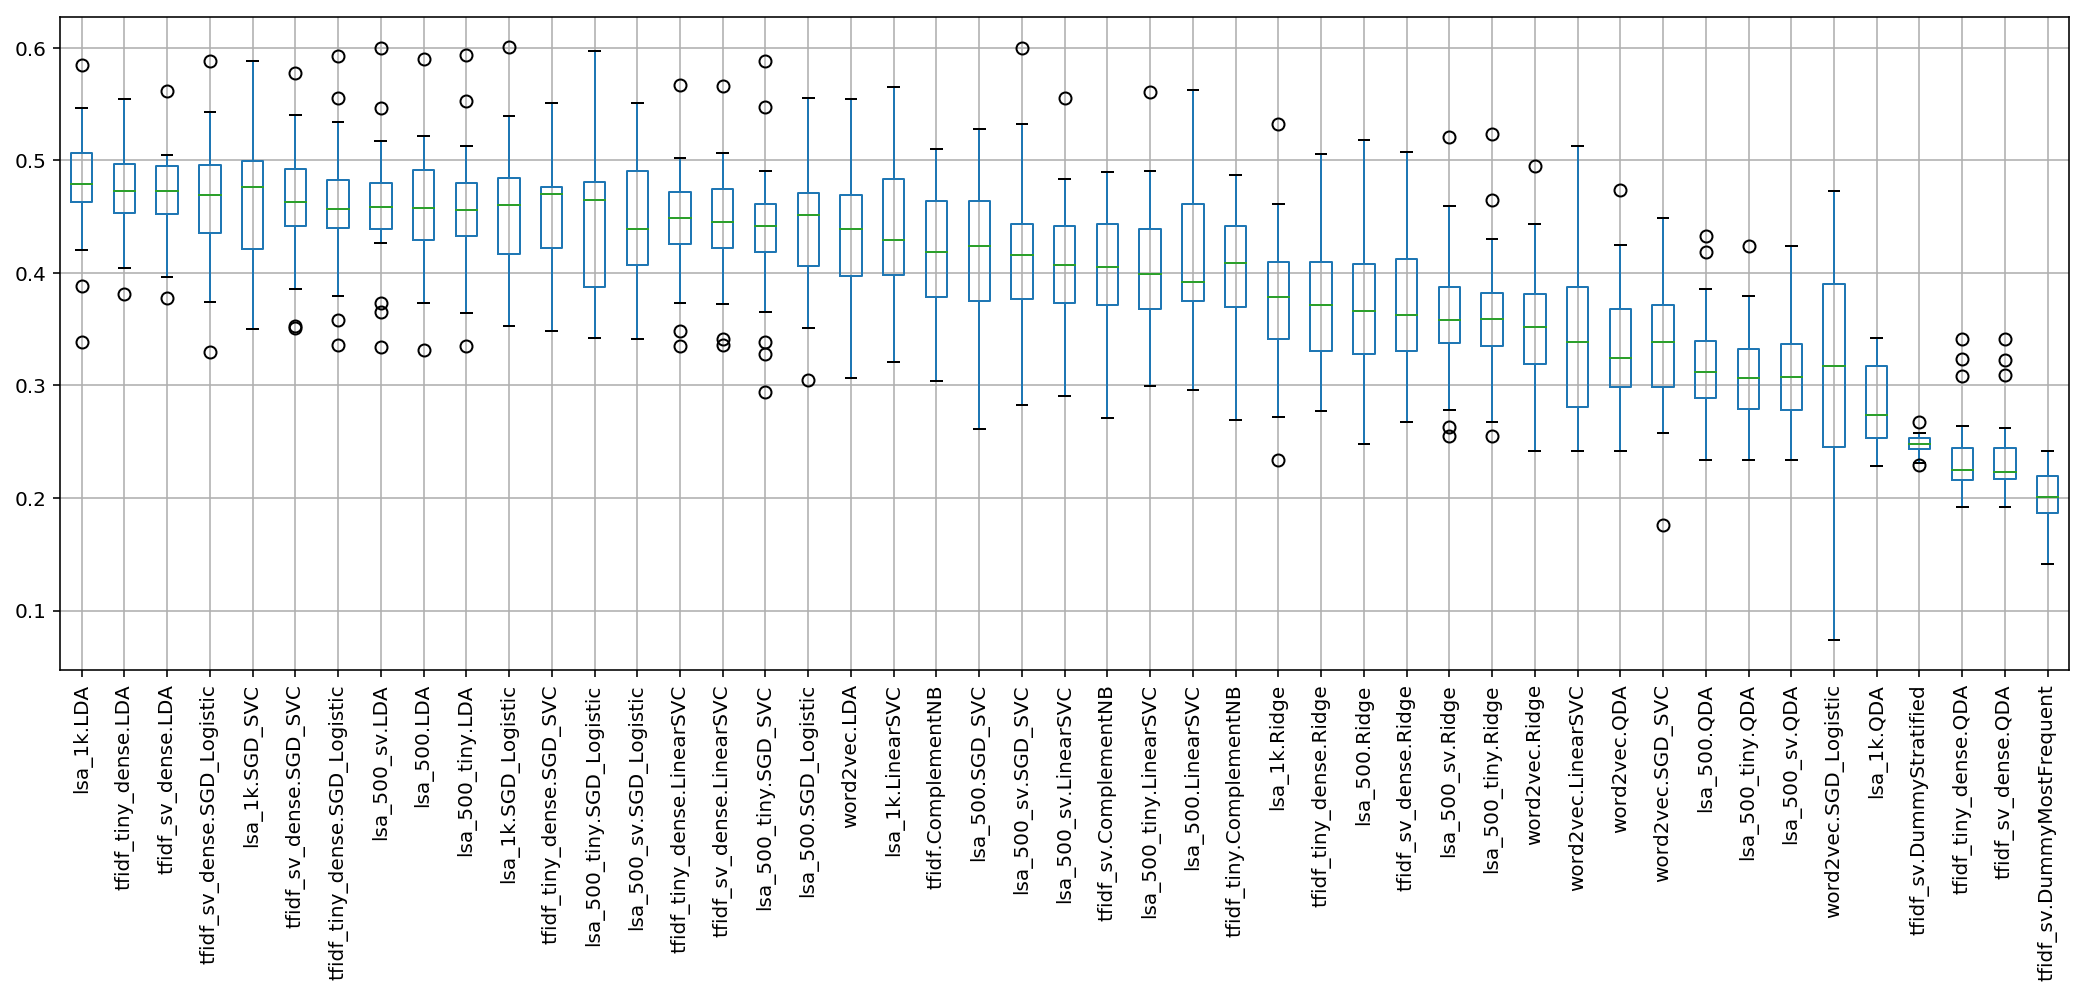

In [35]:
import matplotlib.pyplot as plt

df_test.T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

Let's save the models for future use.

In [ ]:
from fgclassifier.utils import save_model

def clear_cache(model):
    if hasattr(model, 'steps'):
        for (name, step) in model.steps:
            clear_cache(step)
    if hasattr(model, 'cache'):
        model.cache = None
    return model

for name, model in results['models'].items():
    clear_cache(model)
    save_model(model)

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df and ngram range) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.

In [ ]:
model = results['models']['lsa_500_en_LDA']
print(X_test[0:1].shape)
probas = model.predict_proba(X_test[0:1])
probas[0].shape

In [ ]:
model.predict(X_test[0:1])